In [29]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [30]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [31]:
# get csv
# df_long = pd.read_csv("data/exp_TMS.csv")


# files = [
#     "data/LIFESPAN_SZcontrols.csv", 
#     "data/LIFESPAN_agingAZ_all.csv", 
#     "data/LIFESPAN_sommerville.csv", 
#     "data/LIFESPAN_students.csv",
#     "data/TMS_horizonTask.csv",
# ]

files = [
    # "data/exp_TMS.csv", 
    # "data/exp.csv", 
    # "data/exp_0919.csv",
    "data/exp_online_0919.csv",
]
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)


In [32]:
df["trial"] = df["trial"].astype(int)

# Rename value_option columns to match original format (m1, m2)
df = df.rename(columns={"value_option0": "m1", "value_option1": "m2"})

# Redefine pivoting function
def pivot_feature(df, feature, prefix):
    return df.pivot_table(
        index=["subject", "block", "m1", "m2", "uncertainty", "horizon"],
        columns="trial",
        values=feature
    ).rename(columns=lambda x: f"{prefix}{x}")

# Pivot reward, choice, RT
reward_wide = pivot_feature(df, "reward", "r")
choice_wide = pivot_feature(df, "choice", "c")
rt_wide = pivot_feature(df, "RT", "rt")

# Get static columns and merge all together
df_static = df.drop_duplicates(subset=["subject", "block", "m1", "m2", "uncertainty", "horizon"])
df_static = df_static.set_index(["subject", "block", "m1", "m2", "uncertainty", "horizon"])
df_wide = pd.concat([df_static, reward_wide, choice_wide, rt_wide], axis=1).reset_index()

df_wide.columns

Index(['subject', 'block', 'm1', 'm2', 'uncertainty', 'horizon', 'age',
       'gender', 'trial', 'reward', 'RT', 'choice', 'forced', 'mask', 'r0',
       'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'c0', 'c1', 'c2',
       'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'rt0', 'rt1', 'rt2', 'rt3',
       'rt4', 'rt5', 'rt6', 'rt7', 'rt8', 'rt9'],
      dtype='object')

In [33]:
df_wide

,subject,block,m1,m2,uncertainty,horizon,age,gender,trial,reward,...,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7,rt8,rt9
0,0,0,28,6,1,1,33,1,0,42,...,3535.2478,1650.1077,1283.4204,1166.7455,3060.1996,NaN,NaN,NaN,NaN,NaN
1,0,0,48,12,0,6,33,1,0,62,...,1033.4077,783.3887,783.3867,893.3909,2328.4894,933.3997,850.0596,850.0575,866.7274,NaN
2,0,1,22,37,1,6,33,1,0,61,...,1350.0815,1200.0854,1083.4028,1033.4072,3118.5491,2000.1402,2768.5165,1250.0903,1016.7362,950.0733
3,0,1,17,30,0,6,33,1,0,47,...,1033.4027,733.3864,900.0653,705.0473,816.7271,1966.7974,1168.4085,850.0644,766.7187,NaN
4,0,2,11,49,0,6,33,1,0,58,...,1100.0788,816.7247,850.0527,883.3933,2650.1860,1116.7524,900.0618,883.3883,785.0490,733.3904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107399,635,155,33,8,1,6,43,1,0,46,...,599.8992,516.8944,683.0779,599.9543,1034.0029,933.6416,466.9264,533.6191,383.6485,NaN
107400,635,156,17,13,-1,1,43,1,0,48,...,666.2068,599.3662,783.8645,533.9554,NaN,NaN,NaN,NaN,NaN,NaN
107401,635,157,26,39,0,1,43,1,0,64,...,683.5966,733.3335,749.4404,1316.8962,NaN,NaN,NaN,NaN,NaN,NaN
107402,635,158,12,55,0,6,43,1,0,64,...,684.0670,599.9653,632.3177,749.5613,749.7587,383.4958,316.8175,433.7874,450.5013,NaN


In [34]:
df = df_wide.rename(columns={"horizon": "gameLength", "uncertainty": "uc"})

df.columns

Index(['subject', 'block', 'm1', 'm2', 'uc', 'gameLength', 'age', 'gender',
       'trial', 'reward', 'RT', 'choice', 'forced', 'mask', 'r0', 'r1', 'r2',
       'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'c0', 'c1', 'c2', 'c3', 'c4',
       'c5', 'c6', 'c7', 'c8', 'c9', 'rt0', 'rt1', 'rt2', 'rt3', 'rt4', 'rt5',
       'rt6', 'rt7', 'rt8', 'rt9'],
      dtype='object')

In [35]:
df.to_csv("data/my_horizon_data__online_0919.csv", index=False)

In [36]:
# same as sklearn 


seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]

print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())

# X_seq_train = X_seq_train.to_numpy()
# X_seq_test = X_seq_test.to_numpy()
# X_static_train = X_static_train.to_numpy()
# X_static_test = X_static_test.to_numpy()


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  42.0  0.0  41.0  0.0  34.0  0.0  31.0  1.0
1  62.0  0.0  66.0  1.0  63.0  0.0  57.0  1.0
2  61.0  0.0  59.0  0.0  57.0  1.0  56.0  0.0
3  47.0  0.0  37.0  1.0  38.0  1.0  52.0  0.0
4  58.0  0.0  62.0  1.0  58.0  0.0  57.0  1.0
   gameLength  uc
0           1   1
1           6   0
2           6   1
3           6   0
4           6   0

--- Target Data (y) ---
0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: c4, dtype: float64


In [37]:
feature_order_test = np.array(seq_features).reshape(-1, 4, 2)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [38]:
print(X_seq_train.shape)
print(type(X_seq_train))
print(type(y_train))

(85923, 8)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [39]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, 2)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, 2)
print(X_seq_test.shape)
print(type(X_seq_test))

(85923, 4, 2)
<class 'numpy.ndarray'>
[[ 0.45967735 -1.00678488]
 [ 0.45726603  0.99847654]
 [ 0.11720056 -1.00091985]
 [ 0.80325317 -0.98800301]]
(21481, 4, 2)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [40]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [41]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [42]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
print(type(h1_mask))
h1_mask_bool = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


<class 'pandas.core.series.Series'>


In [43]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [44]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [45]:
class RNN(nn.Module):
    def __init__(self, seq_input_size=2, static_input_size=2, hidden_size=64, output_size=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(seq_input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, h_n = self.rnn(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output


In [46]:
class LSTM(nn.Module):
    def __init__(self, seq_input_size=2, static_input_size=2, hidden_size=128, output_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 64), # combine static inputs
            nn.GELU(),
            nn.Linear(64, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, (h_n, c_n) = self.lstm(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [47]:
class GRU(nn.Module):
    def __init__(self, seq_input_size=2, static_input_size=2, hidden_size=64, output_size=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [48]:
class TinyGRU(nn.Module):
    def __init__(self, seq_input_size=2, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyGRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 2), # combine static inputs
            nn.ReLU(),
            nn.Linear(2, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [49]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(seq_inputs, static_inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            preds = model(seq_inputs, static_inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [50]:
model = TinyGRU().to(device)
print(model)

TinyGRU(
  (gru): GRU(2, 2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import matplotlib.pyplot as plt

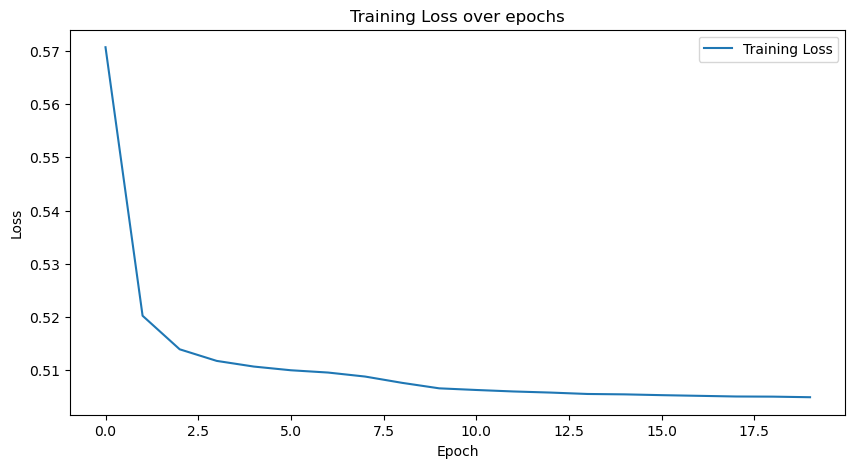

In [ ]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

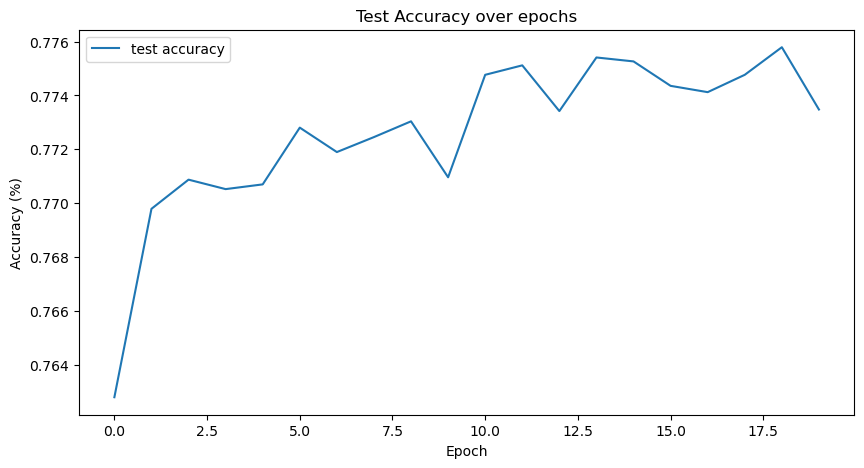

In [ ]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

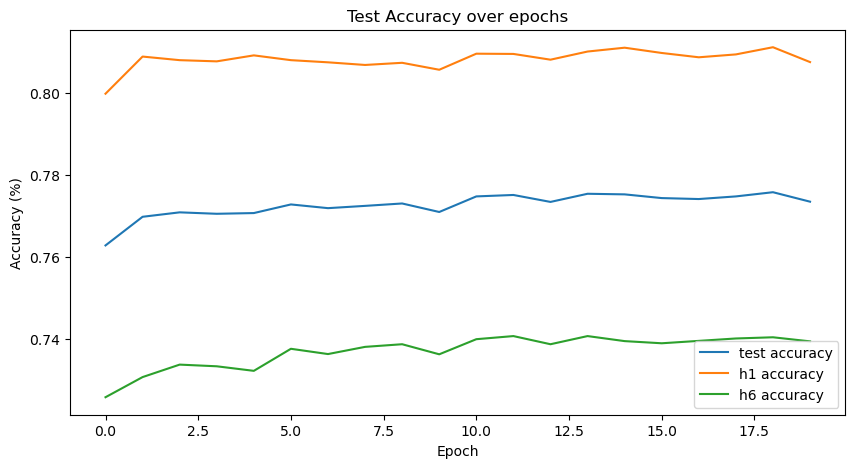

In [ ]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])